## 5.3 계절 등 주기성 필드로 매출 예측하기 (시계열 분석)

### 공통 전처리

In [1]:
# 공통 처리

# 불필요한 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 글꼴 설정
import platform

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='Apple Gothic')

# 데이터프레임 출력용 함수
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress=True, precision=4)

# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format

# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns",None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14

# 난수 시드
random_seed = 123

데이터 집합 배포 페이지 URL
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

#### 데이터 필드 정보

instant 인덱스 
dteday 날짜(yy-mm-dd)  
season 계절 (1: 겨울 2: 봄 3: 여름 4: 가을)  
yr 연도 (0: 2011, 1:2012)  
mnth 월  (1 - 12)  
hr 시간  (0 - 23)  
holiday 휴일  
weekday 요일 (0 - 6)  
workingday  근무일 (1: 근무일 0: 휴일)  
weathersit 날씨 (1: 맑은뒤흐림 2: 안개 3: 약한비 4: 강한비)  
temp 기온 (정규화됨)  
atemp 체감기온 (정규화됨)  
hum 습도 (정규화됨)  
windspeed 풍속 (정규화됨)  
casual 비가입유저 이용수  
registered 가입유저 이용수  
cnt 전체유저 이용수  

### 5.3.4 데이터 읽어 들이기부터 데이터 확인까지

#### 데이터 읽어 들이기

In [2]:
## 역자 주: wget, tail 명령에서 오류가 발생할 경우
# 데이터 집합 URL에서 파일을 직접 내려받아
# notebooks 디렉토리에 압축을 해제하고 진행하면 됩니다.

# 데이터 집합 배포 페이지 URL
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 데이터를 내려받아 압축해제
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
# day.csv 파일을 데이터프레임으로 읽어들임
# 이때 날짜 필드를 parse_dates로 지정한다
df = pd.read_csv('day.csv', parse_dates=[1])

In [4]:
# instant 필드는 일련번호이므로 제거한다
df = df.drop('instant', axis=1)

# 우리말 필드명 정의

columns = [
    '날짜', '계절', '연도', '월', '휴일', '요일', '근무일', '날씨', 
    '온도', '체감온도', '습도', '풍속', 
    '비가입유저_이용수', '가입유저_이용수', '전체유저_이용수'
]

# 필드명을 우리말 필드명으로 변경
df.columns = columns

#### 데이터 확인

In [5]:
# 처음 다섯 줄을 화면에 출력
display(df.head())

# 마지막 다섯 줄을 화면에 출력
display(df.tail())

,날짜,계절,연도,월,휴일,요일,근무일,날씨,온도,체감온도,습도,풍속,비가입유저_이용수,가입유저_이용수,전체유저_이용수
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,날짜,계절,연도,월,휴일,요일,근무일,날씨,온도,체감온도,습도,풍속,비가입유저_이용수,가입유저_이용수,전체유저_이용수
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


### 5.3.5 데이터 전처리와 데이터 분할

#### 데이터 전처리
프로펫에서 사용할 수 있도록 필드명 변경

In [6]:
# '날짜'와 '가입사용자_이용수' 필드만 추출해
# 필드명을 '날짜'는 ds, '가입사용자_이용수'는 y로 
# 바꾼 새 데이터프레임 df를 생성한다

# 데이터프레임 사본을 생성
df2 = df.copy()

# '날짜'와 '가입사용자_이용수' 필드를 추출
df2 = df2[['날짜', '가입유저_이용수']]

# 필드명을 교체
df2.columns = ['ds', 'y']

# 결과 확인
display(df2.head())


,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


#### 데이터 분할
2012년 11월 1일 이전 분은 학습 데이터(x_train), 이후 분은 검증 데이터(x_test)로 삼는다

In [7]:
# 분할 기준 날짜 mday
mday = pd.to_datetime('2012-11-1')

# 학습용 데이터의 index와 검증용 데이터의 index를 생성
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 입력 데이터 분할
x_train = df2[train_index]
x_test = df2[test_index]

# 날짜 데이터 분할(그래프 출력용)
dates_test = df2['ds'][test_index]

### 5.3.6 알고리즘 선택하기

#### 알고리즘 선택

In [9]:
# 라이브러리 임포트
#from fbprophet import Prophet
from prophet import Prophet

# 모델 결정
# seasonality 파라미터를 3으로 설정하는 것이 중요
# 이번 데이터는 일 단위 데이터이므로 daily_seasonality는 불필요함
# weekly_seasonality와 daily_seasonality는 
# True/False 외의 값으로도 지정할 수 있음 (삼각함수의 개수)
# seasonality_mode: additive(기본값) multiplicative

m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative')

Importing plotly failed. Interactive plots will not work.


### 5.3.7 학습 및 예측

#### 학습

In [10]:
# 학습
m1.fit(x_train)

#### 예측

In [11]:
# 예측용 데이터 생성
# (날짜 필드 ds만 들어 있는 데이터프레임)
# 61은 예측을 원하는 기간의 일수(2012-11-1부터 2012-12-31까지)
future1 = m1.make_future_dataframe(periods=61, freq='D')

# 결과 확인
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [12]:
# 예측
# 결과로 데이터프레임이 반환된다
fcst1 = m1.predict(future1)

### 5.3.8 평가

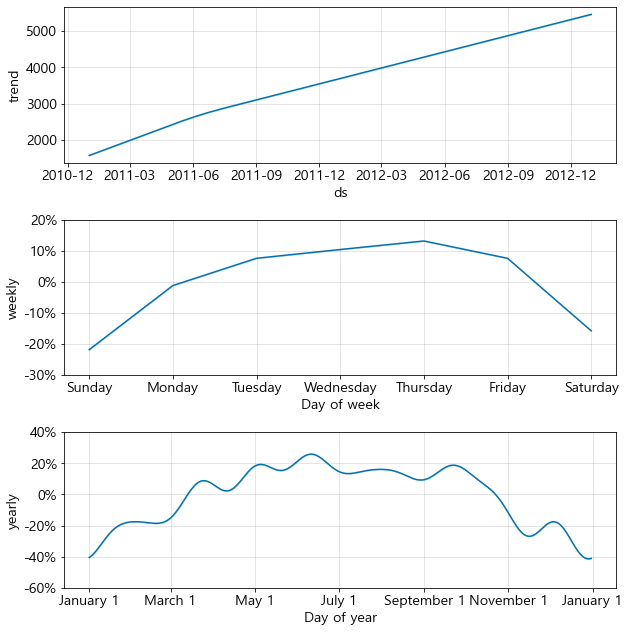

In [13]:
# 요소별 그래프 그리기
# 여기서는 트렌드, 주 단위 주기, 연 단위 주기
fig = m1.plot_components(fcst1)
plt.show()

#### 학습 데이터, 검증 데이터 전체의 그래프

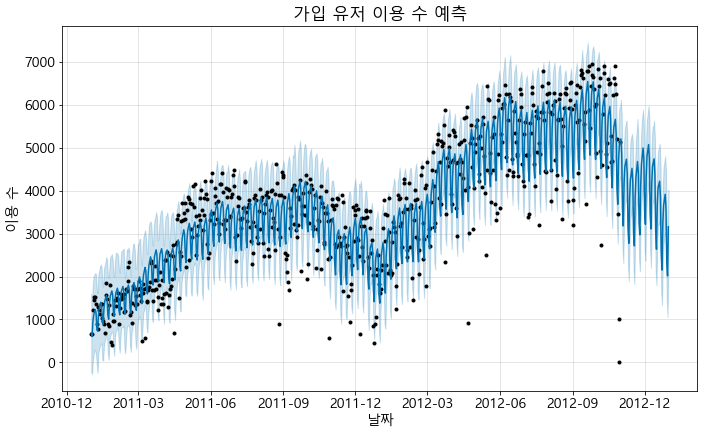

In [14]:
# 학습 데이터, 검증 데이터 전체를 그래프로 출력
fig, ax = plt.subplots(figsize=(10,6))

# 예측 결과를 그래프로 출력(프로펫 제공 함수)
m1.plot(fcst1, ax=ax)

# 제목 및 캡션 설정
ax.set_title('가입 유저 이용 수 예측')
ax.set_xlabel('날짜')
ax.set_ylabel('이용 수')

# 그래프 출력
plt.show()

#### R2값 계산하기

In [15]:
# ypred1: fcst1에서 예측 부분만 추출
ypred1 = fcst1[-61:][['yhat']].values

# ytest1: 예측 기간 중의 정답 데이터
ytest1 = x_test['y'].values

# R2값을 계산
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# 결과 확인
print(f'R2 score:{score:.4f}')

R2 score:0.3734


#### 예측 기간의 시계열 그래프(정답 데이터와 예측 결과)

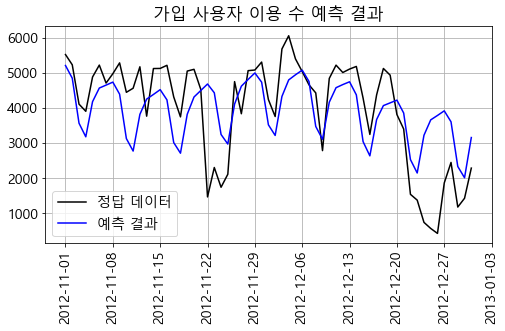

In [16]:
# 시계열 그래프 그리기
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 그래프 그리기
ax.plot(dates_test, ytest1, label='정답 데이터', c='k')
ax.plot(dates_test, ypred1, label='예측 결과', c='b')

# 날짜 눈금 표시
# 목요일마다 날짜를 출력한다
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 날짜 표기를 90도 기울임
ax.tick_params(axis='x', rotation=90)

# 그리드 그리기
ax.grid()
ax.legend()
ax.set_title('가입 사용자 이용 수 예측 결과')

# 그래프 출력
plt.show()

### 튜닝 방법

* 1단계 : '휴일'의 영향을 반영
* 2단계 : 회귀 모델에 '날씨', '온도', '풍속', '습도'를 추가


### 5.3.9 튜닝 (1단계)

#### 1단계
'휴일'의 영향을 반영

In [17]:
# 휴일에 해당하는 날짜 추출
df_holiday = df[df['휴일']==1]
holidays = df_holiday['날짜'].values

# 데이터프레임으로 변환 
df_add = pd.DataFrame({'holiday': 'holi',
    'ds': holidays,
    'lower_window': 0,
    'upper_window': 0
})

# 결과 확인
display(df_add.head())
display(df_add.tail())              

,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [18]:
# 휴일(df_add)을 모델에 반영하기

# 알고리즘 선택
# holidays 파라미터를 추가해 새로운 모델 m2를 생성한다
m2 = Prophet(yearly_seasonality=True,
    weekly_seasonality=True, daily_seasonality=False,
    holidays = df_add, seasonality_mode='multiplicative')

# 학습
m2 = m2.fit(x_train)

# 예측
fcst2 = m2.predict(future1)

#### 튜닝 1단계의 평가

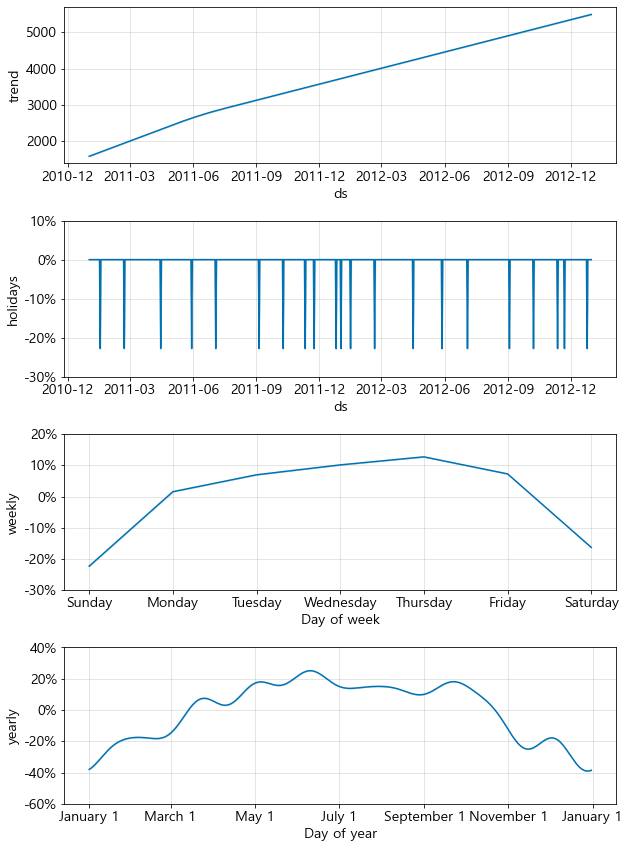

In [19]:
# 요소별 그래프 그리기
fig = m2.plot_components(fcst2)
plt.show()

In [20]:
# R2값 계산하기

# fcst2에서 예측 부분만을 추출
ypred2 = fcst2[-61:][['yhat']].values

# R2값 계산
score2 = r2_score(ytest1, ypred2)

# 결과 확인
r2_text2 = f'R2 score:{score2:.4f}'
print(r2_text2)

R2 score:0.4145


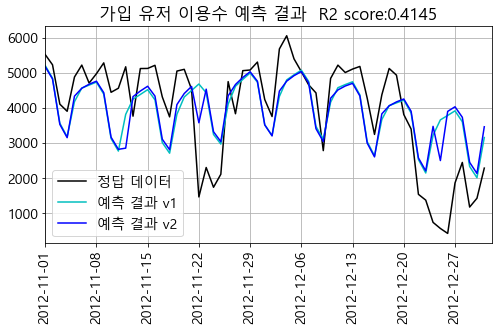

In [21]:
# 시계열 그래프 그리기
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 그래프 그리기
ax.plot(dates_test, ytest1, label='정답 데이터', c='k')
ax.plot(dates_test, ypred1, label='예측 결과 v1', c='c')
ax.plot(dates_test, ypred2, label='예측 결과 v2', c='b')

# 날짜 눈금 표시
# 목요일마다 날짜를 출력한다
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 날짜 표기를 90도 기울임
ax.tick_params(axis='x', rotation=90)

# 시작일과 종료일
sday = pd.to_datetime('2012-11-1')
eday = pd.to_datetime('2013-1-1')
ax.set_xlim(sday, eday) 

# 그리드 표시
ax.grid()
ax.legend()
ax.set_title('가입 유저 이용수 예측 결과  ' + r2_text2)

# 화면에 출력
plt.show()

### 5.3.10 튜닝 (2단계)
'날씨', '온도', '풍속', '습도'를 예측 모델에 반영

In [22]:
# 학습 데이터에 '날씨', '온도', '풍속', '습도'를 추가하기
df3 = pd.concat([df2, df[['날씨', '온도', '풍속', '습도']]], axis=1)

# 입력 데이터 분할
x2_train = df3[train_index]
x2_test = df3[test_index]

# 결과 확인
display(x2_train.tail())

,ds,y,날씨,온도,풍속,습도
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [23]:
# 알고리즘 선택

m3 = Prophet(yearly_seasonality=True, 
    weekly_seasonality=True, daily_seasonality=False,
    seasonality_mode='multiplicative', holidays = df_add)

# add_regressor 함수를 이용해  '날씨', '온도', '풍속', '습도'를 모델에 추가
m3.add_regressor('날씨')
m3.add_regressor('온도')
m3.add_regressor('풍속')
m3.add_regressor('습도')

# 학습
m3.fit(x2_train)

In [24]:
# 예측용 입력 데이터 생성
future3 = df3[['ds', '날씨', '온도', '풍속', '습도']]

# 예측
fcst3 = m3.predict(future3)

In [25]:
### 튜닝 2단계의 평가

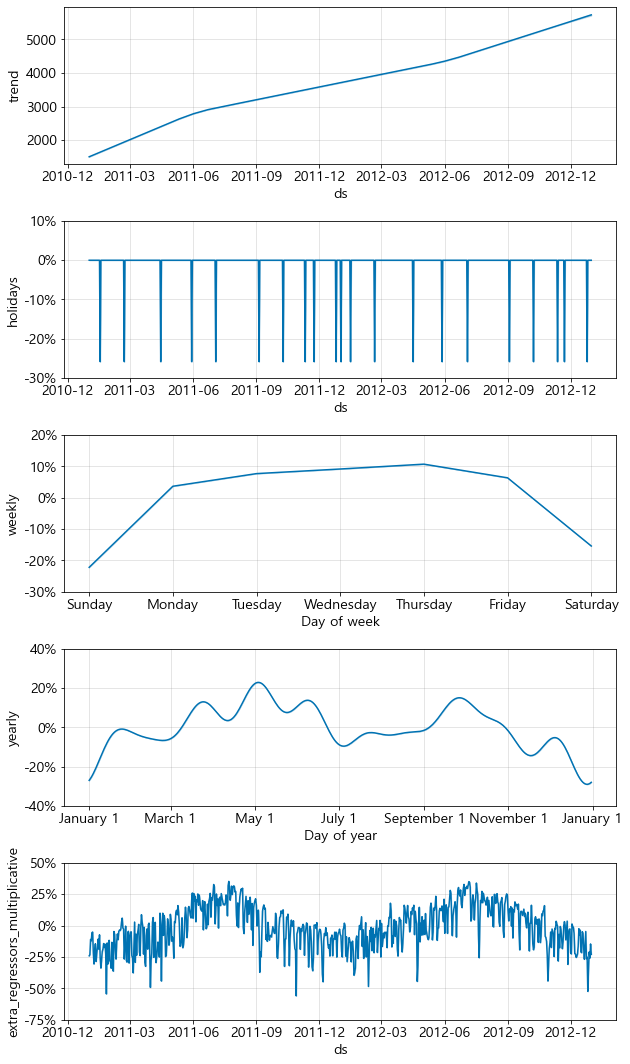

In [26]:
# 요소별 그래프 그리기
fig = m3.plot_components(fcst3)
plt.show()

In [27]:
# R2값 계산하기

# fcst에서 예측 부분만을 추출
ypred3 = fcst3[-61:][['yhat']].values
score3 = r2_score(ytest1, ypred3)

# 결과 확인
r2_text3 = f'R2 score:{score3:.4f}'
print(r2_text3)

R2 score:0.6196


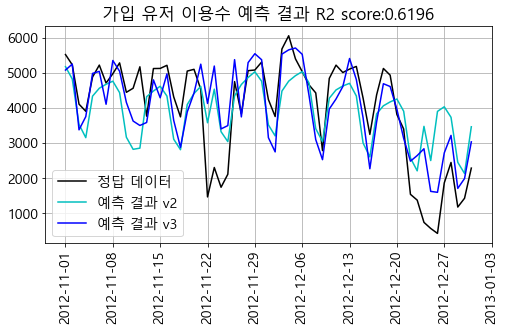

In [28]:
# 시계열 그래프 그리기
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 그래프 그리기
ax.plot(dates_test, ytest1, label='정답 데이터', c='k')
ax.plot(dates_test, ypred2, label='예측 결과 v2', c='c')
ax.plot(dates_test, ypred3, label='예측 결과 v3', c='b')

# 날짜 눈금 표시
# 목요일마다 날짜를 출력한다
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 날짜 표기를 90도 기울임
ax.tick_params(axis='x', rotation=90)

# 그리드 표시
ax.grid()
ax.legend()
ax.set_title('가입 유저 이용수 예측 결과 ' + r2_text3)

# 화면에 출력
plt.show()

### 칼럼 - 아이스크림 구매 예측 (시계열 분석)

#### 데이터 집합 배포 웹 페이지

아이스크림 조사 보고서 
https://www.icecream.or.jp/biz/data/expenditures.html

아래의 엑셀 파일은 이 보고서의 내용을 기초로 만든 것이다.

In [29]:
# 역자 주: 엑셀 파일 호환성 문제로 xlrd는 1.2.0 이하를 사용해야 합니다.

# 데이터 읽어들이기
#url2 = 'https://github.com/makaishi2/\
#sample-data/blob/master/data/ice-sales.xlsx?raw=true'
url2 = './ice-sales.xlsx'

df = pd.read_excel(url2, sheet_name=0)

In [30]:
# 데이터 확인
display(df.head())
display(df.tail())

,年月,支出
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


,年月,支出
55,2019-08-01,1513
56,2019-09-01,996
57,2019-10-01,724
58,2019-11-01,531
59,2019-12-01,584


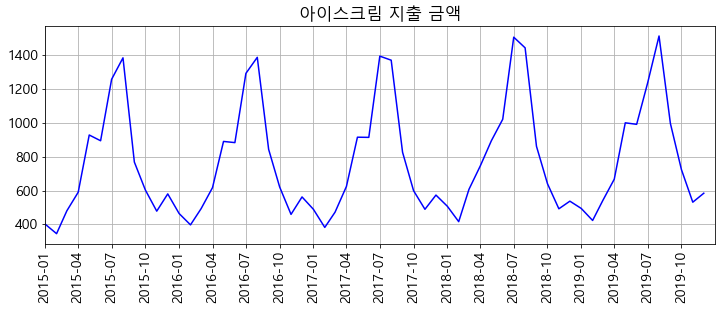

In [32]:
# 시계열 그래프 그리기(아이스크림 지출 금액)
fig, ax = plt.subplots(figsize=(12, 4))

# 그래프 그리기
ax.plot(df['年月'], df['支出'],c='b')

# 3개월 단위로 눈금 표시
month3 = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(month3)

# 날짜 표기를 90도 회전
ax.tick_params(axis='x', rotation=90)

# 시작일과 종료일
sday = pd.to_datetime('2015-1-1')
eday = pd.to_datetime('2019-12-31')
ax.set_xlim(sday, eday) 

# 그리드 표시
ax.grid()
ax.set_title('아이스크림 지출 금액')

# 화면에 출력
plt.show()

In [33]:
# 데이터 전처리
# 데이터 형식을 프로멧에 맞춰 변경
x = df.copy()
x.columns = ['ds', 'y']
display(x.head())

,ds,y
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


In [34]:
# 데이터 분할
# 2019년 1월을 기준으로 학습 데이터와 검증 데이터를 분할
# 기준일 mday를 정의
mday = pd.to_datetime('2019-1-1')

# 학습 데이터 index와 검증 데이터 index를 생성
train_index = x['ds'] < mday
test_index = x['ds'] >= mday

# 입력 데이터 분할
x_train = x[train_index]
x_test = x[test_index]

# 날짜 필드도 그래프 작도를 위해 분할
dates_train = x['ds'][train_index]
dates_test = x['ds'][test_index]

In [36]:
# 알고리즘 선택
# 라이브러리 임포트
#from fbprophet import Prophet
from prophet import Prophet

m = Prophet(yearly_seasonality=5, weekly_seasonality=False, daily_seasonality=False)

In [37]:
# 학습
m = m.fit(x_train)

In [38]:
# 예측
future = x[['ds']]
fcst = m.predict(future)

In [39]:
# 평가

# fcst에서 예측 부분만을 추출
ypred = fcst[-12:]['yhat'].values

# 정답 데이터의 리스트
ytest = x_test['y'].values

# R2값 계산
from sklearn.metrics import r2_score
score = r2_score(ytest, ypred)
score_text = f'R2 score:{score:.4f}'
print(score_text)

R2 score:0.9566


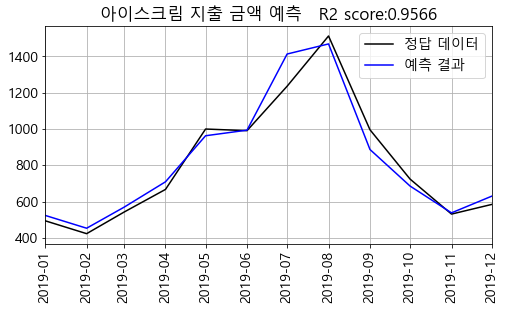

In [40]:
# 시계열 그래프 그리기 (아이스크림 지출 금액)
fig, ax = plt.subplots(figsize=(8, 4))

# 그래프 그리기
ax.plot(dates_test, ytest, label='정답 데이터', c='k')
ax.plot(dates_test, ypred, label='예측 결과', c='b')

# 1개월 단위 눈금 표시
month = mdates.MonthLocator()
ax.xaxis.set_major_locator(month)

# 날짜 표기를 90도 회전
ax.tick_params(axis='x', rotation=90)

# 시작일과 종료일
sday = pd.to_datetime('2019-1-1')
eday = pd.to_datetime('2019-12-1')
ax.set_xlim(sday, eday) 

# 그리드 표시
ax.grid()
ax.legend()
ax.set_title('아이스크림 지출 금액 예측　' + score_text)

# 화면에 출력
plt.show()